<a href="https://colab.research.google.com/github/so-dipe/Web-Scraping-Datasets/blob/main/f1%20web%20scarping%20library%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import plotly.express as px
from datetime import datetime
import warnings
import time
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
# import ssl
# from tempfile import TemporaryFile
# ssl._create_default_https_context = ssl._create_unverified_context

In [27]:
def url_to_soup(url):
  webpage =  urllib.request.urlopen(url)
  return BeautifulSoup(webpage)

def str_to_time(time_column):
  time_column = time_column.copy()
  for i in range(len(time_column)):
    if time_column.iloc[i][0] is not '1':
      time_column.iloc[i] = "0:00.0"
      time_column.iloc[i] = datetime.strptime(time_column.iloc[i], '%M:%S.%f').time()
    else:
      time_column.iloc[i] = datetime.strptime(time_column.iloc[i], '%M:%S.%f').time()
  return time_column

def time_to_int(time_col):
  time_col = time_col.copy()
  for i in range(len(time_col)):
    time_col.iloc[i] = (
        time_col.iloc[i].microsecond +
        (time_col.iloc[i].second * 1_000_000) +
        (time_col.iloc[i].minute * 60 * 1_000_000)
    )
  return time_col

class RaceDataExtractor:
  '''
  Extracts the race data for a particular race
  or extracts all the race data for the year or years specified
  '''

  def __init__(self, years):
    self.years = years
    self.f1_website = 'https://www.formula1.com'
    self.results_url = 'https://www.formula1.com/en/results.html'
    self.years_link = None
    if type(years) is list:
      self.years_link = list()
      for year in years:
        self.years_link.append(self.get_link(year))
    else:
      self.years_link = self.get_link(years) 
  
  def get_link(self, year):
    """
    Gets the link to the results of a given race year/race season
    """
    soup = url_to_soup(self.results_url)
    link = soup.findAll(attrs={'data-value':year}) #find tags
    link = self.f1_website + link[0].get('href')  #get link
    return link

  def get_race_result(self, race_link, year):
    """
    Returns the result of a single as a DataFrame
    """
    racesoup = url_to_soup(race_link)
    circuit = racesoup.findAll(class_='circuit-info')[0].text
    race_location = racesoup.findAll(
        class_='resultsarchive-filter-item-link FilterTrigger selected', 
        attrs={"data-name":"meetingKey"}
    )[0].text.strip()
    no_res = racesoup.findAll(class_='no-results')
    if len(no_res) != 0:
      return pd.DataFrame()
    race_df = pd.read_html(race_link)[0]
    race_df['Circuit'] = circuit
    race_df['Location'] = race_location
    race_df['year'] = year
    race_df.dropna(axis=1, inplace=True)
    #add fastest lap
    fastlap_df = self.get_fastestlaps(race_link).drop(columns=['Pos', 'No', 'Lap'])
    fastlap_df.rename(columns={'Time':'Fastest Lap'}, inplace=True)
    if min(fastlap_df.shape) == 0:
      pass
    else:
      race_df = race_df.merge(fastlap_df, on=['Driver', 'Car'])
    #add quali result
    quali_df = self.get_quali(race_link).drop(columns=['Pos', 'No', 'Laps'])
    race_df = race_df.merge(quali_df, on=['Driver', 'Car'])
    ##add free practice results
    # fp_df = self.get_practice(race_link).drop(columns='No')
    # race_df = race_df.merge(fp_df, on=['Driver', 'Car'])
    #add starting grid
    start_grid = self.get_startgrid(race_link)
    if 'Time' in start_grid.columns:
      start_grid.drop(columns='Time')
    start_grid.rename(columns={'Pos':'Starting Grid'}, inplace=True)
    race_df = race_df.merge(start_grid, on=['Driver', 'No', 'Car'])
    #add pitstop summary
    # pitstops = self.get_pitstops(race_link).drop(columns=['Lap', 'Time of day', 'Time'])
    # pitstops.rename(columns={'Total':'Total Pitstop Time'}, inplace=True)
    # pitstops = pitstops.groupby('Driver').max().reset_index()
    # race_df = race_df.merge(pitstops, on=['Driver', 'No', 'Car'])
    return race_df

  def getAllraces(self, concat=True):
    allraces_df_ls = list()
    allraces_df = pd.DataFrame()
    if type(self.years) is list:
      for year in self.years:
        racesoup = url_to_soup(self.get_link(year))
        races = racesoup.findAll(attrs={"data-name":"meetingKey"})
        i = 1
        for race in races[1:]:
          race_link = self.f1_website + race.get('href')
          race_df = self.get_race_result(race_link, year)
          race_df['race_num'] = i
          i = i + 1
          if concat is True:
            allraces_df = pd.concat([allraces_df, race_df])
          else:
            allraces_df_ls.append(race_df)
    else:
      racesoup = url_to_soup(self.get_link(self.years))
      races = racesoup.findAll(attrs={"data-name":"meetingKey"})
      i = 1
      for race in races[1:]:
        race_link = self.f1_website + race.get('href')
        race_df = self.get_race_result(race_link, self.years)
        race_df['race_num'] = i
        i = i + 1
        if concat is True:
          allraces_df = pd.concat([allraces_df, race_df])
        else:
          allraces_df_ls.append(race_df)
    if concat is True:
      return allraces_df
    return allraces_df_ls

  def get_fastestlaps(self, race_link):
    racesoup = url_to_soup(race_link)
    fastestlaps = racesoup.findAll(class_="side-nav-item-link ArchiveLink ", attrs={'data-value':'fastest-laps'})
    if len(fastestlaps) > 1:
      fastestlaps = self.f1_website + fastestlaps[0].get('href')
      fastlap_df = pd.read_html(fastestlaps)[0].dropna(axis=1)
      return fastlap_df
    else:
      return pd.DataFrame(columns=['Pos', 'No', 'Lap', 'Time', 'Driver', 'Car'])

  def get_pitstops(self, race_link):
    racesoup = url_to_soup(race_link)
    pitstops = racesoup.findAll(class_="side-nav-item-link ArchiveLink ", attrs={'data-value':'pit-stop-summary'})
    pitstops = self.f1_website + pitstops[0].get('href')
    pitstop_df = pd.read_html(pitstops)[0].dropna(axis=1)
    return pitstop_df

  def get_startgrid(self, race_link):
    racesoup = url_to_soup(race_link)
    startgrid = racesoup.findAll(class_="side-nav-item-link ArchiveLink ", attrs={'data-value':'starting-grid'})
    startgrid = self.f1_website + startgrid[0].get('href')
    startgrid_df = pd.read_html(startgrid)[0].dropna(axis=1)
    return startgrid_df
  
  def get_quali(self, race_link):
    racesoup = url_to_soup(race_link)
    quali = racesoup.findAll(class_="side-nav-item-link ArchiveLink ", attrs={'data-value':'qualifying'})
    quali = self.f1_website + quali[0].get('href')
    quali_df = pd.read_html(quali)[0].drop(columns=['Unnamed: 0', 'Unnamed: 9']).fillna('ELIMINATED')
    return quali_df

  def get_practice(self, race_link):
    practice_num = ['1', '2', '3']
    racesoup = url_to_soup(race_link)
    sessions = []
    for num in practice_num:
      practice = racesoup.findAll(class_="side-nav-item-link ArchiveLink ", attrs={'data-value':f'practice-{num}'})
      practice = self.f1_website + practice[0].get('href')
      practice_df = pd.read_html(practice)[0].drop(columns=['Unnamed: 0', 'Unnamed: 8', 'Gap'])
      practice_df.rename(columns={'POS':f'POS FP{num}', 'Time':f'FP{num} Time'}, inplace=True)
      practice_df.drop(columns=['Laps', 'Pos'], inplace=True)
      sessions.append(practice_df)
    practice_df = sessions[0].merge(sessions[1], on=['No', 'Driver', 'Car']).merge(sessions[2], on=['No', 'Driver', 'Car'])
    return practice_df

In [ ]:
class RaceData(RaceDataExtractor):
  def __init__(self, year):
    self.year = year
    super().__init__(year)
    self.raw_data = super().getAllraces()
    self.wdcPlot_df = None

  def getWDC(self):
    race_df = self.raw_data
    wdc_df = pd.pivot_table(race_df, index=['Car', 'Driver'], columns=['race_num', 'Location']).fillna('0')['PTS'].astype(int)
    pts_ls = []
    for column in wdc_df.columns:
      pts = wdc_df.loc[:,:column].sum(axis=1)
      pts_ls.append(pts)
    k = 1
    i = 0
    for column in wdc_df.columns:
      wdc_df.insert(loc=k, column=(column[0], 'Total PTS'), value=pts_ls[i])
      i = i + 1
      k = k + 2
    return wdc_df

  def plotWDC(self):
    wdc_df = self.getWDC()
    wdc_df = (
        wdc_df
        .reset_index()
        .drop(columns='Car')
        .set_index('Driver')
        .transpose()
        .reset_index()
        .drop(columns='race_num')
        .set_index('Location')
        .transpose()
    )
    # points = wdc_df['Total PTS']
    races = wdc_df.drop(columns='Total PTS').columns
    wdc_df = wdc_df.drop(columns=races)
    wdc_df.columns = races
    wdc_df = wdc_df.transpose()
    for col in wdc_df.columns:
      if pd.DataFrame(wdc_df[col]).shape[1] > 1:
        new_vals = wdc_df[col].sum(axis=1)
        wdc_df.drop(columns=col, inplace=True)
        wdc_df[col] = new_vals
    fig = px.line(
        (
            wdc_df.transpose()
            .sort_values(by=wdc_df.index[-1], ascending=False)
            .transpose()
        ),
        markers=True
    )
    self.wdcPlot_df = wdc_df
    return fig
  
  def plot_quali(self, race_loc):
    race_data = self.raw_data[self.raw_data['Location'] == race_loc]
    quali_data = race_data[['Driver', 'Car', 'Q1', 'Q2', 'Q3']]
    quali_data['Q1'] = str_to_time(quali_data['Q1'])
    quali_data['Q2'] = str_to_time(quali_data['Q2'])
    quali_data['Q3'] = str_to_time(quali_data['Q3'])
    quali_data['Q1 int'] = time_to_int(quali_data['Q1'])
    quali_data['Q2 int'] = time_to_int(quali_data['Q2'])
    quali_data['Q3 int'] = time_to_int(quali_data['Q3'])
    temp_series = quali_data[quali_data['Q1 int'] != 0]
    quali_data['Q1 scale'] = (
        (temp_series['Q1 int'] - temp_series['Q1 int'].min())/
        (temp_series['Q1 int'].max() - temp_series['Q1 int'].min())
    )
    temp_series = quali_data[quali_data['Q2 int'] != 0]
    quali_data['Q2 scale'] = (
        (temp_series['Q2 int'] - temp_series['Q2 int'].min())/
        (temp_series['Q2 int'].max() - temp_series['Q2 int'].min())
    )
    temp_series = quali_data[quali_data['Q3 int'] != 0]
    quali_data['Q3 scale'] = (
        (temp_series['Q3 int'] - temp_series['Q3 int'].min())/
        (temp_series['Q3 int'].max() - temp_series['Q3 int'].min())
    )
    quali_construct = quali_data.groupby('Car').min().reset_index()
    figures = []

    #Plot Q1
    fig, ax = plt.subplots(figsize=(16, 9))
    ax2 = ax.twinx()
    pd.concat(
        [
            quali_data[['Driver', 'Q1 scale']][quali_data['Q1 scale'].isna()],
            quali_data[['Driver', 'Q1 scale']].dropna().sort_values(by='Q1 scale', ascending=False)            
        ]
    ).plot(kind='barh', x='Driver', ax=ax, label='Q1')
    quali_data['Q1 scale neg'] = - quali_data['Q1 scale']
    # quali_construct['Q1 scale neg'] = - quali_construct['Q1 scale']
    pd.concat(
        [
            quali_data[['Car', 'Q1 scale neg']][quali_data['Q1 scale neg'].isna()],
            quali_data[['Car', 'Q1 scale neg']].dropna().sort_values(by='Q1 scale neg')            
        ]
    ).plot(kind='barh', x='Car', ax=ax2, label='Q1')
    plt.plot([0, 0],[-220, 220], color='red')
    plt.plot([0.25, 0.25],[-220, 220], color='green', linestyle='dashed', label='<25% slower')
    plt.plot([-0.25, -0.25],[-220, 220], color='green', linestyle='dashed')
    plt.plot([0.5, 0.5],[-220, 220], color='blue', linestyle='dashed', label='<50% slower')
    plt.plot([-0.5, -0.5],[-220, 220], color='blue', linestyle='dashed')
    ax.legend()
    figures.append(fig)

    #Plot Q2
    fig2, ax = plt.subplots(figsize=(16, 9))
    ax2 = ax.twinx()
    pd.concat(
        [
            # quali_data[['Driver', 'Q2 scale']][quali_data['Q2 scale'].isna()],
            quali_data[['Driver', 'Q2 scale']].dropna().sort_values(by='Q2 scale', ascending=False)            
        ]
    ).plot(kind='barh', x='Driver', ax=ax, label='Q2')
    quali_data['Q2 scale neg'] = - quali_data['Q2 scale']
    # quali_construct['Q1 scale neg'] = - quali_construct['Q1 scale']
    pd.concat(
        [
            # quali_data[['Car', 'Q2 scale neg']][quali_data['Q2 scale neg'].isna()],
            quali_data[['Car', 'Q2 scale neg']].dropna().sort_values(by='Q2 scale neg')            
        ]
    ).plot(kind='barh', x='Car', ax=ax2, label='Q2')
    plt.plot([0, 0],[-220, 220], color='red')
    plt.plot([0.25, 0.25],[-220, 220], color='green', linestyle='dashed', label='<25% slower')
    plt.plot([-0.25, -0.25],[-220, 220], color='green', linestyle='dashed')
    plt.plot([0.5, 0.5],[-220, 220], color='blue', linestyle='dashed', label='<50% slower')
    plt.plot([-0.5, -0.5],[-220, 220], color='blue', linestyle='dashed')
    ax.legend()
    figures.append(fig2)

    #Plot Q3
    fig3, ax = plt.subplots(figsize=(16, 9))
    ax2 = ax.twinx()
    pd.concat(
        [
            # quali_data[['Driver', 'Q3 scale']][quali_data['Q3 scale'].isna()],
            quali_data[['Driver', 'Q3 scale']].dropna().sort_values(by='Q3 scale', ascending=False)            
        ]
    ).plot(kind='barh', x='Driver', ax=ax, label='Q3')
    quali_data['Q3 scale neg'] = - quali_data['Q3 scale']
    # quali_construct['Q1 scale neg'] = - quali_construct['Q1 scale']
    pd.concat(
        [
            # quali_data[['Car', 'Q3 scale neg']][quali_data['Q3 scale neg'].isna()],
            quali_data[['Car', 'Q3 scale neg']].dropna().sort_values(by='Q3 scale neg')            
        ]
    ).plot(kind='barh', x='Car', ax=ax2, label='Q3')
    plt.plot([0, 0],[-220, 220], color='red')
    plt.plot([0.25, 0.25],[-220, 220], color='green', linestyle='dashed', label='<25% slower')
    plt.plot([-0.25, -0.25],[-220, 220], color='green', linestyle='dashed')
    plt.plot([0.5, 0.5],[-220, 220], color='blue', linestyle='dashed', label='<50% slower')
    plt.plot([-0.5, -0.5],[-220, 220], color='blue', linestyle='dashed')
    ax.legend()
    figures.append(fig3)

    # pd.concat(
    #     [
    #         quali_data[['Driver', 'Q2 scale']].dropna().sort_values(by='Q2 scale'),
    #         quali_data[['Driver', 'Q2 scale']][quali_data['Q2 scale'].isna()]
    #     ]
    # ).plot.barh(stacked=True, ax=ax, x='Driver', color='red')#(kind='barh', x='Driver', ax=ax)
    return figures
    
  def compare_speed(self, race_loc):
      race_data = self.raw_data[self.raw_data['Location'] == race_loc]
      quali_data = race_data[['Driver', 'Car', 'Q1', 'Q2', 'Q3']]
      quali_data['Q1'] = str_to_time(quali_data['Q1'])
      quali_data['Q2'] = str_to_time(quali_data['Q2'])
      quali_data['Q3'] = str_to_time(quali_data['Q3'])
      quali_data['Q1 int'] = time_to_int(quali_data['Q1'])
      quali_data['Q2 int'] = time_to_int(quali_data['Q2'])
      quali_data['Q3 int'] = time_to_int(quali_data['Q3'])
      temp_series = quali_data[quali_data['Q1 int'] != 0]
      quali_data['Q1 scale'] = (
          (temp_series['Q1 int'] - temp_series['Q1 int'].min())
      )
      temp_series = quali_data[quali_data['Q2 int'] != 0]
      quali_data['Q2 scale'] = (
          (temp_series['Q2 int'] - temp_series['Q2 int'].min())
      )
      temp_series = quali_data[quali_data['Q3 int'] != 0]
      quali_data['Q3 scale'] = (
          (temp_series['Q3 int'] - temp_series['Q3 int'].min())
      )
      quali_construct = quali_data.groupby('Car').min().reset_index()
      figures = []

      #Plot Q1
      fig, ax = plt.subplots(figsize=(16, 9))
      ax2 = ax.twinx()
      pd.concat(
          [
              quali_data[['Driver', 'Q1 scale']][quali_data['Q1 scale'].isna()],
              quali_data[['Driver', 'Q1 scale']].dropna().sort_values(by='Q1 scale', ascending=False)            
          ]
      ).plot(kind='barh', x='Driver', ax=ax, label='Q1')
      quali_data['Q1 scale neg'] = - quali_data['Q1 scale']
      # quali_construct['Q1 scale neg'] = - quali_construct['Q1 scale']
      pd.concat(
          [
              quali_data[['Car', 'Q1 scale neg']][quali_data['Q1 scale neg'].isna()],
              quali_data[['Car', 'Q1 scale neg']].dropna().sort_values(by='Q1 scale neg')            
          ]
      ).plot(kind='barh', x='Car', ax=ax2, label='Q1')
      plt.plot([0, 0],[-220, 220], color='red')
      ax.legend()
      figures.append(fig)

      #Plot Q2
      fig2, ax = plt.subplots(figsize=(16, 9))
      ax2 = ax.twinx()
      pd.concat(
         [
              # quali_data[['Driver', 'Q2 scale']][quali_data['Q2 scale'].isna()],
              quali_data[['Driver', 'Q2 scale']].dropna().sort_values(by='Q2 scale', ascending=False)            
          ]
      ).plot(kind='barh', x='Driver', ax=ax, label='Q2')
      quali_data['Q2 scale neg'] = - quali_data['Q2 scale']
      # quali_construct['Q1 scale neg'] = - quali_construct['Q1 scale']
      pd.concat(
          [
              # quali_data[['Car', 'Q2 scale neg']][quali_data['Q2 scale neg'].isna()],
              quali_data[['Car', 'Q2 scale neg']].dropna().sort_values(by='Q2 scale neg')            
          ]
      ).plot(kind='barh', x='Car', ax=ax2, label='Q2')
      plt.plot([0, 0],[-220, 220], color='red')
      ax.legend()
      figures.append(fig2)

      #Plot Q3  
      fig3, ax = plt.subplots(figsize=(16, 9))
      ax2 = ax.twinx()
      pd.concat(
          [
              # quali_data[['Driver', 'Q3 scale']][quali_data['Q3 scale'].isna()],
              quali_data[['Driver', 'Q3 scale']].dropna().sort_values(by='Q3 scale', ascending=False)            
          ]
      ).plot(kind='barh', x='Driver', ax=ax, label='Q3')
      quali_data['Q3 scale neg'] = - quali_data['Q3 scale']
      # quali_construct['Q1 scale neg'] = - quali_construct['Q1 scale']
      pd.concat(
          [
              # quali_data[['Car', 'Q3 scale neg']][quali_data['Q3 scale neg'].isna()],
              quali_data[['Car', 'Q3 scale neg']].dropna().sort_values(by='Q3 scale neg')            
          ]
      ).plot(kind='barh', x='Car', ax=ax2, label='Q3')
      plt.plot([0, 0],[-220, 220], color='red')
      ax.legend()
      figures.append(fig3)

      # pd.concat(
      #     [
      #         quali_data[['Driver', 'Q2 scale']].dropna().sort_values(by='Q2 scale'),
      #         quali_data[['Driver', 'Q2 scale']][quali_data['Q2 scale'].isna()]
      #     ]
      # ).plot.barh(stacked=True, ax=ax, x='Driver', color='red')#(kind='barh', x='Driver', ax=ax)
      return figures


In [ ]:
df = RaceData('2019')

In [ ]:
df.raw_data['Location'].unique()

array(['Australia', 'Bahrain', 'China', 'Azerbaijan', 'Spain', 'Monaco',
       'Canada', 'France', 'Austria', 'Great Britain', 'Germany',
       'Hungary', 'Belgium', 'Italy', 'Singapore', 'Russia', 'Japan',
       'Mexico', 'United States', 'Brazil', 'Abu Dhabi'], dtype=object)

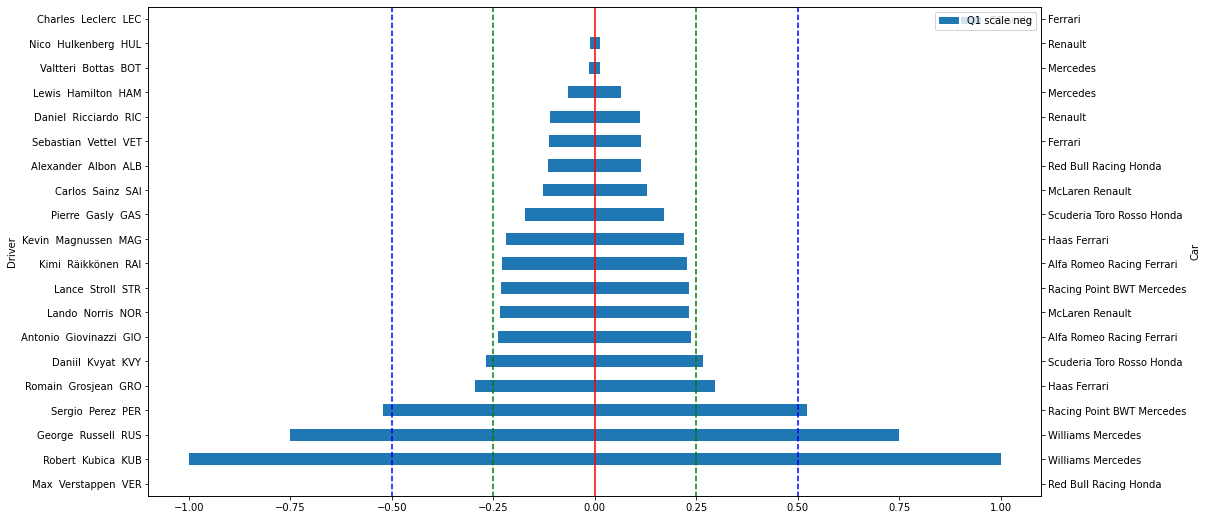

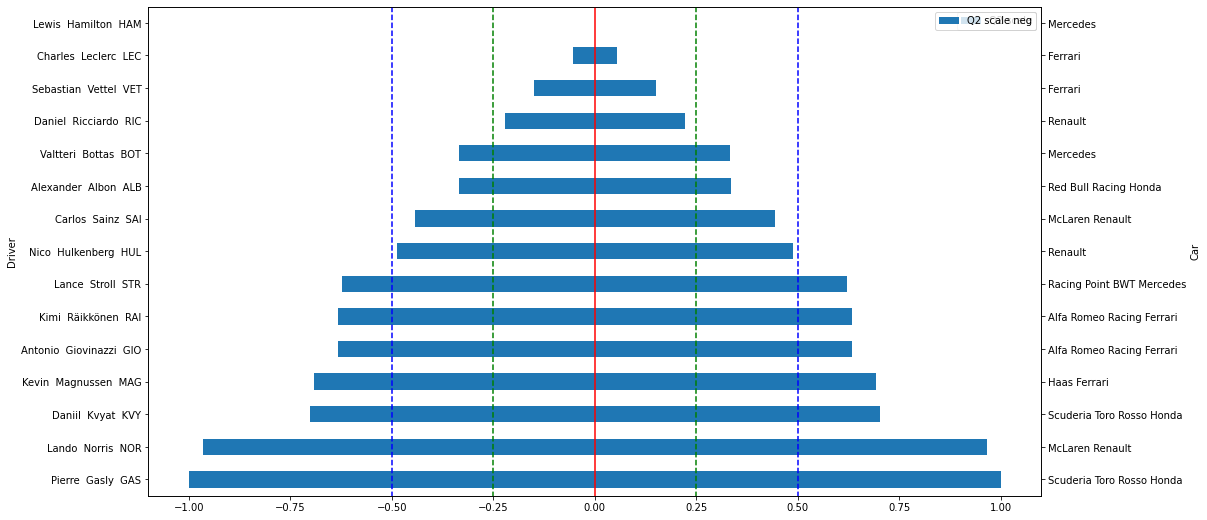

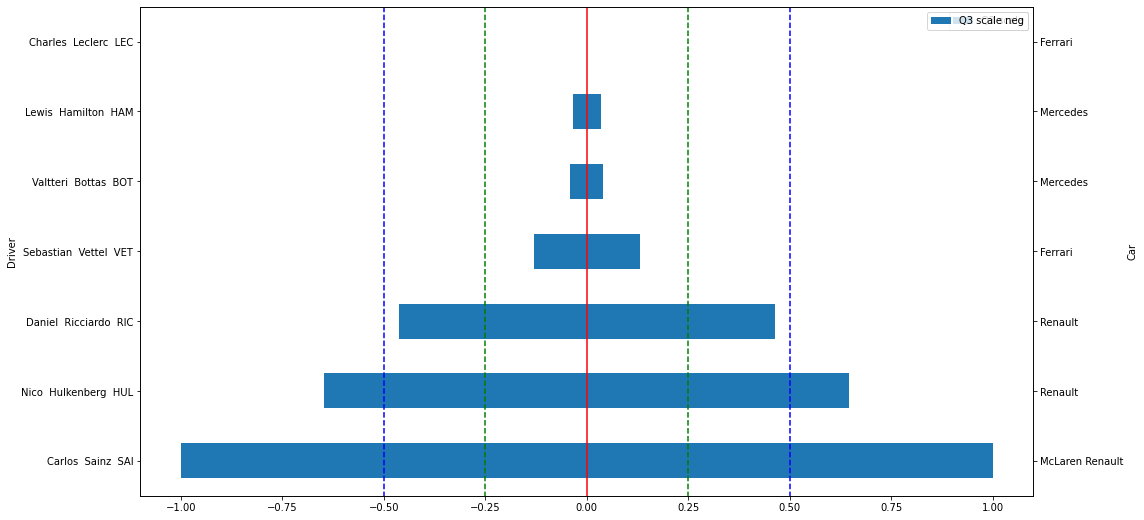

In [ ]:
quali_data = df.plot_quali('Italy')

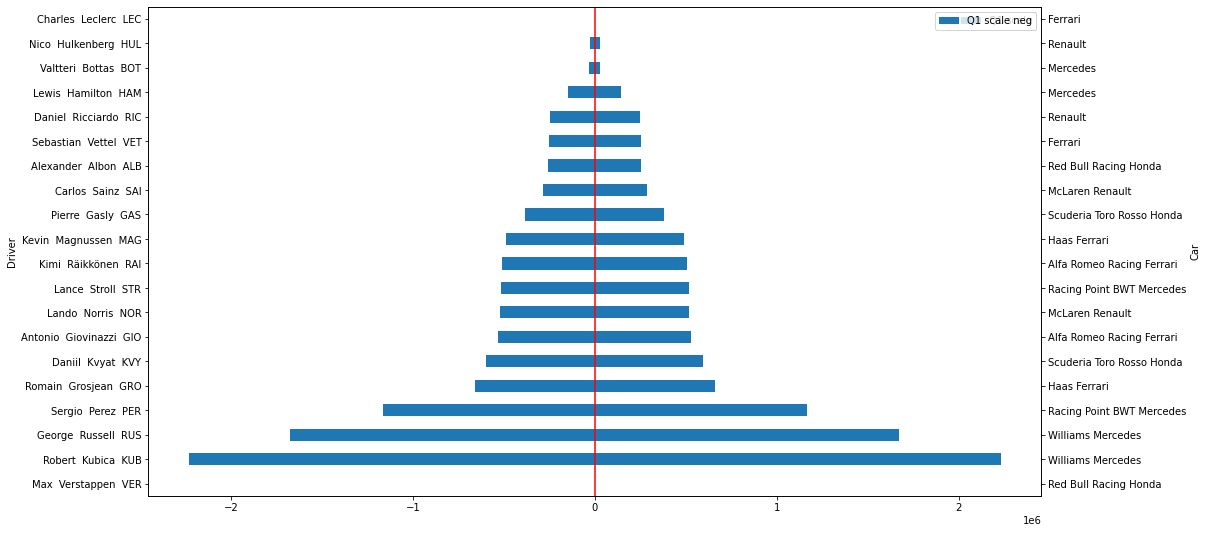

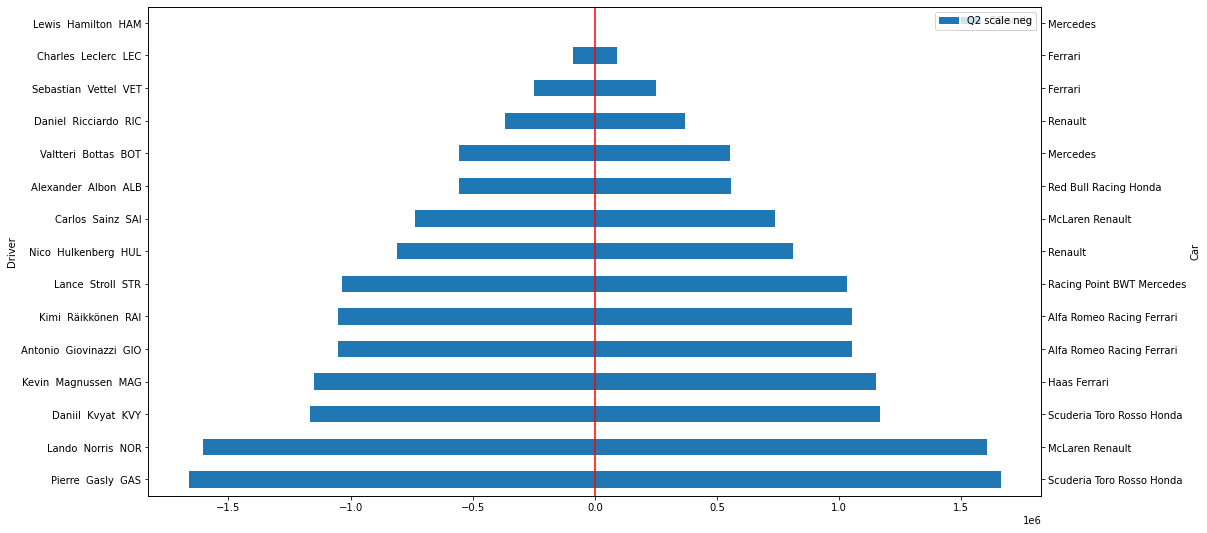

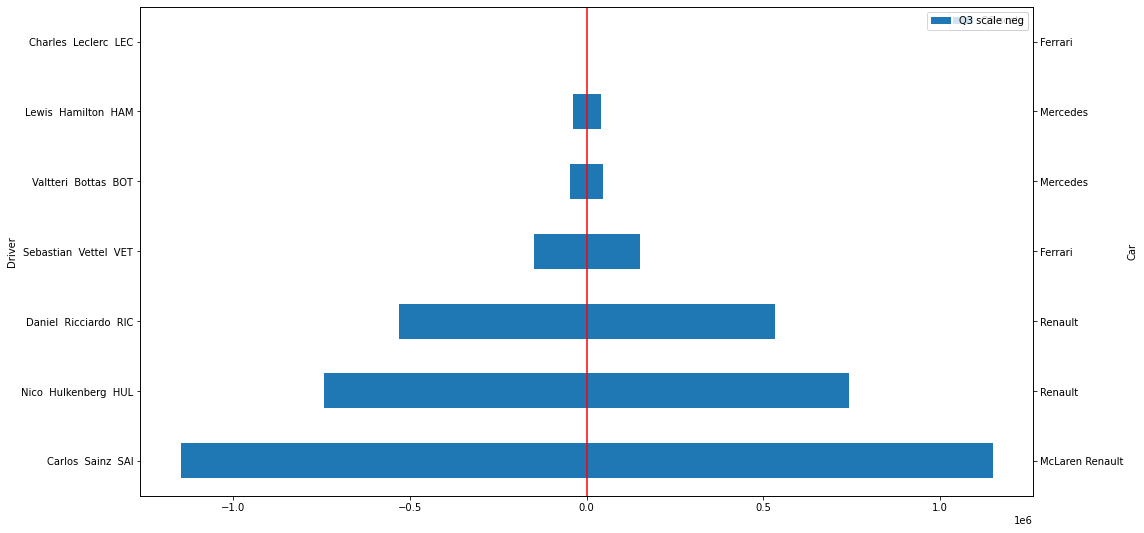

In [ ]:
compare_speed = df.compare_speed('Italy')